In [1]:
import os
import csv
from sklearn.utils import shuffle

samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
del samples[0]
print(len(samples))
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
#print(len(train_samples))
#print(len(validation_samples))

8036


In [2]:
import cv2
import numpy as np
#import sklearn

def generator(samples, batch_size=32,flag = 'train'):
    num_samples = len(samples)
    if flag == 'train':
        views = ['left','center','right']
    else:
        views = ['center']
    correction = 0.2
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for view in views:
                    image = None
                    angle = float(batch_sample[3])
                    if view =='center':
                        name = 'data/IMG/'+batch_sample[0].split('/')[-1]
                        image = cv2.imread(name)
                    elif view =='left':
                        name = 'data/IMG/'+batch_sample[1].split('/')[-1]
                        image = cv2.imread(name)
                        angle +=correction
                    elif view =='right':
                        name = 'data/IMG/'+batch_sample[2].split('/')[-1]
                        image = cv2.imread(name)
                        angle -=correction
                            
                    # Convert the image to RGB
                    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)   
                    images.append(image)
                    angles.append(angle)
                    
                    #Augmentation
                    
                    #Flip the image
                    image = cv2.flip(image, 1)
                    angle *= -1.0
                    images.append(image)
                    angles.append(angle)
                    
                    
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

ch, row, col = 3, 160, 320  # Trimmed image format

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, Reshape, Cropping2D
from keras.layers.pooling import MaxPooling2D


model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160,320,3)))

model.add(Cropping2D(cropping=((70,25), (0,0))))
#model.add(Reshape((80,160,3)))
#model.add(Lambda(lambda x: cv2.resize(x, None, fx=0.5, fy=0.5)))
#model.add(Flatten(input_shape = (160,320,3)))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
#model.add(MaxPooling2D())

model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
#model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch= 
                    len(train_samples)*2*3, validation_data=validation_generator,
                    nb_val_samples=len(validation_samples), nb_epoch=5)

model.save('model.h5')

Epoch 1/5
38568/38568 [==============================] - 65s - loss: 0.0202 - val_loss: 0.0157
Epoch 2/5
38568/38568 [==============================] - 63s - loss: 0.0168 - val_loss: 0.0176
Epoch 3/5
38568/38568 [==============================] - 63s - loss: 0.0159 - val_loss: 0.0173
Epoch 4/5
38568/38568 [==============================] - 63s - loss: 0.0153 - val_loss: 0.0137
Epoch 5/5
38568/38568 [==============================] - 63s - loss: 0.0146 - val_loss: 0.0141


dict_keys(['val_loss', 'loss'])


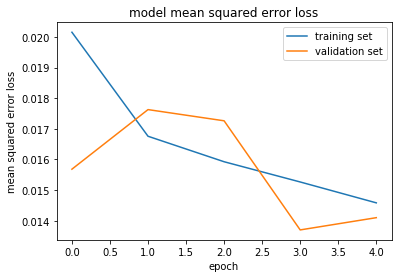

In [7]:
### print the keys contained in the history object
print(history.history.keys())
import matplotlib.pyplot as plt
%matplotlib inline
### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()